In [1]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy.stats import chi2_contingency
# # import math
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score 
from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import LabelEncoder
import ModelFunctions
from sklearn.model_selection import train_test_split
import pickle


C:\Users\nining\AppData\Local\Temp\ipykernel_9408\2044537783.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:

data = pd.read_csv("data_pre_process.csv")

# Xtrain_fso, Xval_fso, Xtest_fso, Ytrain_fso, Yval_fso, Ytest_fso = \
#     ModelFunctions.split_data(data, "FSO_Att",drop_column = ["Frequency",'RFL_Att'],valtest_available = 0) # Frequency doesn't relate to FSO_Att
# Xtrain_rfl, Xval_rfl, Xtest_rfl, Ytrain_rfl, Yval_rfl, Ytest_rfl = \
#     ModelFunctions.split_data(data, "RFL_Att",drop_column = ['FSO_Att'],valtest_available = 0)

Xtrain_ori, Xval_ori, Ytrain_rfl, Yval_rfl = \
train_test_split(data, data["RFL_Att"],test_size=0.3, random_state=42)

train_rfl_fso = pd.DataFrame()
test_rfl_fso = pd.DataFrame()
train_rfl_fso["rfl_ori"] = Ytrain_rfl
train_rfl_fso["fso_ori"] = Xtrain_ori["FSO_Att"]
test_rfl_fso["rfl_ori"] = Yval_rfl
test_rfl_fso["fso_ori"] = Xval_ori["FSO_Att"]

print(train_rfl_fso.head(5))
#print(Xtrain_rfl.head(5))

Xtrain_rfl = Xtrain_ori.drop(columns=["RFL_Att","FSO_Att"])
Xval_rfl = Xval_ori.drop(columns=["RFL_Att","FSO_Att"])





         rfl_ori   fso_ori
12119   4.383918  8.976157
12395   6.731623  7.067532
45768  11.700958  2.876168
43767  10.923080  2.736651
79697  11.600878  7.997360


In [3]:
rfl_rf_model = RandomForestRegressor(n_estimators=130, max_depth=25, \
                                        min_samples_leaf=1, random_state=25,\
                                        min_samples_split=2, oob_score=True, n_jobs=6)
fso_rf_model = RandomForestRegressor(n_estimators = 130, max_depth=30, \
                                     min_samples_leaf = 1, random_state = 25,\
                                     min_samples_split =2, oob_score=True, n_jobs=6 )

In [4]:

FSO_hybrid_rmse_list = []
FSO_hybrid_r2_list = []
FSO_generic_rmse_list = []
FSO_generic_r2_list =[]
synop_codes = [0, 3, 4, 5, 6, 7, 8]
for code in synop_codes:
    test_rfl_fso = pd.DataFrame()
    Xtrain_ori, Xval_ori, Ytrain_rfl, Yval_rfl = \
    train_test_split(data, data["RFL_Att"],test_size=0.3, random_state=42)
    
    Xtrain_rfl_s, Ytrain_rfl_s = ModelFunctions.filter_data_by_SYNOPCode(Xtrain_ori, Ytrain_rfl, code)
    Xval_rfl_s, Yval_rfl_s = ModelFunctions.filter_data_by_SYNOPCode(Xval_ori, Yval_rfl, code)
    
    test_rfl_fso["rfl_ori"] = Yval_rfl_s
    test_rfl_fso["fso_ori"] = Xval_rfl_s["FSO_Att"]
    Xval_rfl_s1 = Xval_rfl_s.drop(columns=["RFL_Att","FSO_Att"])
    
    with open('hybrid_rfl_first_model.pkl', 'rb') as file:
        rfl_first_model = pickle.load(file)
    ytest_rfl_pred = rfl_first_model.predict(Xval_rfl_s1)
 
    Xval_fso_s = Xval_rfl_s1
    with open('hybrid_fso_first_model.pkl', 'rb') as file:
            fso_first_model = pickle.load(file)
    ytest_fso_pred_first = fso_first_model.predict(Xval_fso_s)
    
    Xval_fso_s['RFL_Att_pred'] = ytest_rfl_pred
    with open('hybrid_fso_second_model.pkl', 'rb') as file:
            fso_second_model = pickle.load(file)
    ytest_fso_pred = fso_second_model.predict(Xval_fso_s)

    test_fso_mse = mean_squared_error( test_rfl_fso["fso_ori"], ytest_fso_pred)
    test_fso_rmse = np.sqrt(test_fso_mse)
    test_fso_r2 = r2_score( test_rfl_fso["fso_ori"], ytest_fso_pred)

    FSO_hybrid_rmse_list.append(test_fso_rmse)
    FSO_hybrid_r2_list.append(test_fso_r2)

    test_fso_mse = mean_squared_error( test_rfl_fso["fso_ori"], ytest_fso_pred_first)
    test_fso_rmse = np.sqrt(test_fso_mse)
    test_fso_r2 = r2_score( test_rfl_fso["fso_ori"], ytest_fso_pred_first)

    FSO_generic_rmse_list.append(test_fso_rmse)
    FSO_generic_r2_list.append(test_fso_r2)


    
    
    

In [6]:

hybrid_rmse_list = [0.3411163926547755, 0.3398586949557999, 0.39462038079270484, 0.4439325635220148, 0.7503015737461519, 0.39347920546351206, 1.0029610411302974,0.8315212857016931, 1.4537104701481156, 0.7762719779719901, 0.8117585633375641, 0.8430004112969007, 1.2604106674125701, 0.776761383356399]

hybrid_rmse_ave= sum(hybrid_rmse_list) / len(hybrid_rmse_list)
hybrid_rmse_ave

hybrid_r2_list = [0.982061920769037, 0.9878865198601287, 0.9391754042574623, 0.9764871743460536, 0.9648914120835255, 0.9461421862162538, 0.8931870042232432,0.9423067360309648, 0.9727445525412936, 0.9600119935950835, 0.9493805614581917, 0.9611303005932564, 0.9526742453879395, 0.9588241956691771]
hybrid_r2_ave= sum(hybrid_r2_list) / len(hybrid_r2_list)
hybrid_r2_ave

generic_rmse_list = [0.34773945343743795, 0.34925659418666133, 0.39136171142466675, 0.4249843852128945, 0.751113624272716, 0.4112627550724703, 0.9728857160357329,0.8093048973890475, 1.3587210037282096, 0.742349986465593, 0.7704261252088893, 0.8084996658847208, 1.283976616575483, 0.7289436507248795]
generic_rmse_ave= sum(generic_rmse_list) / len(generic_rmse_list)
generic_rmse_ave

generic_r2_list = [0.9813585928675164, 0.9872073243124202, 0.9401758030478369, 0.9784515138450489, 0.9648153749900575, 0.9411638955924206, 0.8994968618123561,0.9453484221997173, 0.9761900733502887, 0.963430472880893, 0.954404123473379, 0.964246768692903, 0.950887998191434, 0.963737749520836]
generic_r2_ave= sum(generic_r2_list) / len(generic_r2_list)
generic_r2_ave


specific_rmse_list =  [0.4564406839512591,0.5113898930689583,0.4501033001987254,0.7983258849772373,1.0172438026519397,
 0.3694156589895368,1.12858283577548,1.158982264139424,2.215152452469044,1.224324068616785,1.1200685984855208,
 1.3132837442502583,1.9066897615483664,1.165079562152118]
specific_rmse_ave= sum(specific_rmse_list) / len(specific_rmse_list)
specific_rmse_ave

specific_r2_list=  [0.8912562687920282,0.9147437819281292,0.9094837050442288,0.9039914914517572,
 0.9093580716485414,0.8804147309144938,0.907351694228949,0.9680698498717544,0.9692787649585118,0.9036510249030706,0.9238158078121552,
 0.9375699609372334,0.9439605125389304,0.8510264952119321]

specific_r2_ave= sum(specific_r2_list) / len(specific_r2_list)
specific_r2_ave


0.915283725731551

In [5]:
print(FSO_hybrid_rmse_list)
print(FSO_hybrid_r2_list)
print(FSO_generic_rmse_list)
print(FSO_generic_r2_list)

[0.8315212857016931, 1.4537104701481156, 0.7762719779719901, 0.8117585633375641, 0.8430004112969007, 1.2604106674125701, 0.776761383356399]
[0.9423067360309648, 0.9727445525412936, 0.9600119935950835, 0.9493805614581917, 0.9611303005932564, 0.9526742453879395, 0.9588241956691771]
[0.8093048973890475, 1.3587210037282096, 0.742349986465593, 0.7704261252088893, 0.8084996658847208, 1.283976616575483, 0.7289436507248795]
[0.9453484221997173, 0.9761900733502887, 0.963430472880893, 0.954404123473379, 0.964246768692903, 0.950887998191434, 0.963737749520836]


In [6]:
import pickle
RFL_hybrid_rmse_list = []
RFL_hybrid_r2_list = []
RFL_generic_rmse_list = []
RFL_generic_r2_list =[]
synop_codes = [0, 3, 4, 5, 6, 7, 8]
for code in synop_codes:
    test_rfl_fso = pd.DataFrame()
    Xtrain_ori, Xval_ori, Ytrain_rfl, Yval_rfl = \
    train_test_split(data, data["FSO_Att"],test_size=0.3, random_state=42)
    
    Xtrain_fso_s, Ytrain_fso_s = ModelFunctions.filter_data_by_SYNOPCode(Xtrain_ori, Ytrain_rfl, code)
    Xval_fso_s, Yval_fso_s = ModelFunctions.filter_data_by_SYNOPCode(Xval_ori, Yval_rfl, code)
    
    test_rfl_fso["rfl_ori"] = Xval_fso_s["RFL_Att"]
    test_rfl_fso["fso_ori"] = Yval_fso_s
    Xval_fso_s1 = Xval_fso_s.drop(columns=["RFL_Att","FSO_Att"])
    
    with open('hybrid_fso_first_model.pkl', 'rb') as file:
        fso_first_model = pickle.load(file)
    ytest_fso_pred = fso_first_model.predict(Xval_fso_s1)
 
    Xval_rfl_s = Xval_fso_s1
    with open('hybrid_rfl_first_model.pkl', 'rb') as file:
            rfl_first_model = pickle.load(file)
    ytest_rfl_pred_first = rfl_first_model.predict(Xval_rfl_s)
    
    Xval_rfl_s['FSO_Att_pred'] = ytest_fso_pred
    with open('hybrid_rfl_second_model.pkl', 'rb') as file:
            rfl_second_model = pickle.load(file)
    ytest_rfl_pred = rfl_second_model.predict(Xval_rfl_s)

    test_rfl_mse = mean_squared_error( test_rfl_fso["rfl_ori"], ytest_rfl_pred)
    test_rfl_rmse = np.sqrt(test_rfl_mse)
    test_rfl_r2 = r2_score( test_rfl_fso["rfl_ori"], ytest_rfl_pred)

    RFL_hybrid_rmse_list.append(test_rfl_rmse)
    RFL_hybrid_r2_list.append(test_rfl_r2)


    test_rfl_mse = mean_squared_error( test_rfl_fso["rfl_ori"], ytest_rfl_pred_first)
    test_rfl_rmse = np.sqrt(test_rfl_mse)
    test_rfl_r2 = r2_score( test_rfl_fso["rfl_ori"], ytest_rfl_pred_first)

    RFL_generic_rmse_list.append(test_rfl_rmse)
    RFL_generic_r2_list.append(test_rfl_r2)


    
    
    

In [7]:
print(RFL_hybrid_rmse_list)
print(RFL_hybrid_r2_list)
print(RFL_generic_rmse_list)
print(RFL_generic_r2_list)


[0.3411163926547755, 0.3398586949557999, 0.39462038079270484, 0.4439325635220148, 0.7503015737461519, 0.39347920546351206, 1.0029610411302974]
[0.982061920769037, 0.9878865198601287, 0.9391754042574623, 0.9764871743460536, 0.9648914120835255, 0.9461421862162538, 0.8931870042232432]
[0.34773945343743795, 0.34925659418666133, 0.39136171142466675, 0.4249843852128945, 0.751113624272716, 0.4112627550724703, 0.9728857160357329]
[0.9813585928675164, 0.9872073243124202, 0.9401758030478369, 0.9784515138450489, 0.9648153749900575, 0.9411638955924206, 0.8994968618123561]


In [8]:
[0.34636384810279125, 0.3465903873243071, 0.4138148323038372, 0.44354608398783796, 0.7515687422086754, 0.3909454301068701, 1.0157315945886751]
[0.9815057863968765, 0.9874018960468983, 0.9331144481783775, 0.9765280961934977, 0.9647727236393876, 0.9468335784253075, 0.8904496192013075]
[0.3477394534374379, 0.3492565941866618, 0.39136171142466675, 0.4249843852128945, 0.751113624272716, 0.4112627550724704, 0.972885716035733]
[0.9813585928675164, 0.9872073243124201, 0.9401758030478369, 0.9784515138450489, 0.9648153749900575, 0.9411638955924206, 0.8994968618123561]

[0.9813585928675164,
 0.9872073243124201,
 0.9401758030478369,
 0.9784515138450489,
 0.9648153749900575,
 0.9411638955924206,
 0.8994968618123561]

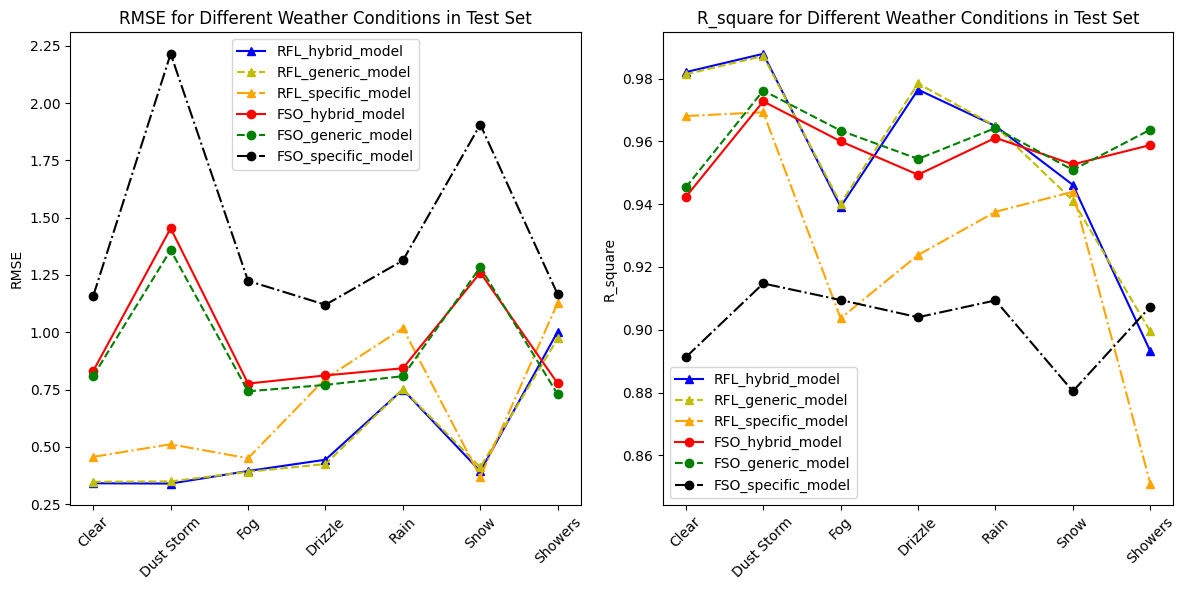

In [9]:
weather_list = ["Clear","Dust Storm","Fog","Drizzle","Rain","Snow","Showers"]
FSO_specific_rmse_list = [1.158982264139424,2.215152452469044,1.224324068616785,1.1200685984855208,
 1.3132837442502583,1.9066897615483664,1.165079562152118]
RFL_specific_rmse_list = [0.4564406839512591,0.5113898930689583,0.4501033001987254,0.7983258849772373,1.0172438026519397,
 0.3694156589895368,1.12858283577548]
RFL_specific_r2_list= [0.9680698498717544,0.9692787649585118,0.9036510249030706,0.9238158078121552,
 0.9375699609372334,0.9439605125389304,0.8510264952119321]
FSO_specific_r2_list = [0.8912562687920282,0.9147437819281292,0.9094837050442288,0.9039914914517572,
 0.9093580716485414,0.8804147309144938,0.907351694228949]
# Create the first subplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(weather_list, RFL_hybrid_rmse_list, color='b', marker='^', label='RFL_hybrid_model')
plt.plot(weather_list, RFL_generic_rmse_list, color='y', marker='^', linestyle='--', label='RFL_generic_model')
plt.plot(weather_list, RFL_specific_rmse_list, color='orange', marker='^', linestyle='-.', label='RFL_specific_model')
plt.plot(weather_list, FSO_hybrid_rmse_list, color='r', marker='o', label='FSO_hybrid_model')
plt.plot(weather_list, FSO_generic_rmse_list, color='g', marker='o', linestyle='--', label='FSO_generic_model')
plt.plot(weather_list, FSO_specific_rmse_list, color='k', marker='o', linestyle='-.', label='FSO_specific_model')

# Add labels and title
plt.ylabel('RMSE')
plt.title('RMSE for Different Weather Conditions in Test Set')
plt.xticks(rotation=45)
plt.legend()

# Create the second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(weather_list, RFL_hybrid_r2_list, color='b', marker='^', label='RFL_hybrid_model')
plt.plot(weather_list, RFL_generic_r2_list, color='y', marker='^', linestyle='--', label='RFL_generic_model')
plt.plot(weather_list, RFL_specific_r2_list, color='orange', marker='^', linestyle='-.', label='RFL_specific_model')
plt.plot(weather_list, FSO_hybrid_r2_list, color='r', marker='o', label='FSO_hybrid_model')
plt.plot(weather_list, FSO_generic_r2_list, color='g', marker='o', linestyle='--', label='FSO_generic_model')
plt.plot(weather_list, FSO_specific_r2_list, color='k', marker='o', linestyle='-.', label='FSO_specific_model')

# Add labels and title
plt.ylabel('R_square')
plt.title('R_square for Different Weather Conditions in Test Set')
plt.xticks(rotation=45)
plt.legend() 

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


# Hybrid Model trained with different weather conditions

In [10]:
rfl_rf_model = RandomForestRegressor(n_estimators=130, max_depth=25, \
                                        min_samples_leaf=1, random_state=25,\
                                        min_samples_split=2, oob_score=True, n_jobs=6)

fso2_rf_model = RandomForestRegressor(n_estimators = 150, max_depth=29, \
                                     min_samples_leaf = 1, random_state = 25,\
                                     min_samples_split =2, oob_score=True, n_jobs=6 )

fso_rf_model = RandomForestRegressor(n_estimators = 130, max_depth=30, \
                                     min_samples_leaf = 1, random_state = 25,\
                                     min_samples_split =2, oob_score=True, n_jobs=6 )
rfl2_rf_model = RandomForestRegressor(n_estimators=150, max_depth=26, \
                                        min_samples_leaf=1, random_state=25,\
                                        min_samples_split=2, oob_score=True, n_jobs=6)

In [11]:
FSO_hybrid_rmse_list1 = []
FSO_hybrid_r2_list1 = []

synop_codes = [0, 3, 4, 5, 6, 7, 8]
data = pd.read_csv("data_pre_process.csv")
for code in synop_codes:
    test_rfl_fso = pd.DataFrame()
    train_rfl_fso = pd.DataFrame()
    Xtrain_ori, Xval_ori, Ytrain_rfl, Yval_rfl = \
    train_test_split(data, data["RFL_Att"],test_size=0.3, random_state=42)
    
    Xtrain_rfl_s, Ytrain_rfl_s = ModelFunctions.filter_data_by_SYNOPCode(Xtrain_ori, Ytrain_rfl, code)
    Xval_rfl_s, Yval_rfl_s = ModelFunctions.filter_data_by_SYNOPCode(Xval_ori, Yval_rfl, code)
    # print(Xtrain_rfl_s.shape,Ytrain_rfl_s.shape)
    # print(Xval_rfl_s.shape,Yval_rfl_s.shape)

    # 原始的att.
    train_rfl_fso["rfl_ori"] = Ytrain_rfl_s
    train_rfl_fso["fso_ori"] = Xtrain_rfl_s["FSO_Att"]
    test_rfl_fso["rfl_ori"] = Yval_rfl_s
    test_rfl_fso["fso_ori"] = Xval_rfl_s["FSO_Att"]
    # print(train_rfl_fso,train_rfl_fso.shape)
    # print(test_rfl_fso,test_rfl_fso.shape)
    # rfl_first train and test X Yt
    Xval_rfl_s1 = Xval_rfl_s.drop(columns=["RFL_Att","FSO_Att"])
    Xtrain_rfl_s1 = Xtrain_rfl_s.drop(columns=["RFL_Att","FSO_Att"])
    
    rfl_first_model = rfl_rf_model.fit(Xtrain_rfl_s1, Ytrain_rfl_s)
    ytrain_rfl_pred = rfl_first_model.predict(Xtrain_rfl_s1)
    ytest_rfl_pred = rfl_first_model.predict(Xval_rfl_s1)
 
    Xtrain_fso_s = Xtrain_rfl_s1
    Xtrain_fso_s['RFL_Att_pred'] = ytrain_rfl_pred
    Ytrain_fso = train_rfl_fso["fso_ori"]
    
    Xval_fso_s = Xval_rfl_s1
    Xval_fso_s['RFL_Att_pred'] = ytest_rfl_pred
    Yval_fso = test_rfl_fso["fso_ori"]

    fso_second_model = fso2_rf_model.fit(Xtrain_fso_s, Ytrain_fso)
    ytrain_fso_pred = fso_second_model.predict(Xtrain_fso_s)
    ytest_fso_pred = fso_second_model.predict(Xval_fso_s)

    test_fso_mse = mean_squared_error( test_rfl_fso["fso_ori"], ytest_fso_pred)
    test_fso_rmse = np.sqrt(test_fso_mse)
    test_fso_r2 = r2_score( test_rfl_fso["fso_ori"], ytest_fso_pred)

    FSO_hybrid_rmse_list1.append(test_fso_rmse)
    FSO_hybrid_r2_list1.append(test_fso_r2)



In [12]:
print("FSO_hybrid_rmse_list1:",FSO_hybrid_rmse_list1) 
print("FSO_hybrid_r2_list1:",FSO_hybrid_r2_list1)

FSO_hybrid_rmse_list1: [0.8363697225730119, 1.8602666663664822, 0.7062162381064223, 0.9862850913255518, 0.9344132132364842, 1.3926516483827518, 0.8378813200322445]
FSO_hybrid_r2_list1: [0.9416319784379614, 0.9553678417980265, 0.9669038609256156, 0.9252745561984193, 0.9522433833723933, 0.9422225457515382, 0.9520893729482783]


In [13]:
RFL_hybrid_rmse_list1 = []
RFL_hybrid_r2_list1 = []

synop_codes = [0, 3, 4, 5, 6, 7, 8]

for code in synop_codes:
    test_rfl_fso = pd.DataFrame()
    train_rfl_fso = pd.DataFrame()
    Xtrain_ori, Xval_ori, Ytrain_fso, Yval_fso = \
    train_test_split(data, data["FSO_Att"],test_size=0.3, random_state=42)
    
    Xtrain_fso_s, Ytrain_fso_s = ModelFunctions.filter_data_by_SYNOPCode(Xtrain_ori, Ytrain_fso, code)
    Xval_fso_s, Yval_fso_s = ModelFunctions.filter_data_by_SYNOPCode(Xval_ori, Yval_fso, code)
    # print(Xtrain_rfl_s.shape,Ytrain_rfl_s.shape)
    # print(Xval_rfl_s.shape,Yval_rfl_s.shape)

    # 原始的att.
    train_rfl_fso["rfl_ori"] = Xtrain_fso_s["RFL_Att"]
    train_rfl_fso["fso_ori"] = Ytrain_fso_s
    test_rfl_fso["rfl_ori"] = Xval_fso_s["RFL_Att"]
    test_rfl_fso["fso_ori"] = Yval_fso_s
    # print(train_rfl_fso,train_rfl_fso.shape)
    # print(test_rfl_fso,test_rfl_fso.shape)
    # rfl_first train and test X Yt
    Xval_fso_s1 = Xval_fso_s.drop(columns=["RFL_Att","FSO_Att"])
    Xtrain_fso_s1 = Xtrain_fso_s.drop(columns=["RFL_Att","FSO_Att"])
    
    fso_first_model = fso_rf_model.fit(Xtrain_fso_s1, Ytrain_fso_s)
    ytrain_fso_pred = fso_first_model.predict(Xtrain_fso_s1)
    ytest_fso_pred = fso_first_model.predict(Xval_fso_s1)
 
    Xtrain_rfl_s = Xtrain_fso_s1
    Xtrain_rfl_s['FSO_Att_pred'] = ytrain_fso_pred
    Ytrain_rfl = train_rfl_fso["rfl_ori"]
    
    Xval_rfl_s = Xval_fso_s1
    Xval_rfl_s['FSO_Att_pred'] = ytest_fso_pred
    Yval_rfl = test_rfl_fso["rfl_ori"]

    rfl_second_model = rfl2_rf_model.fit(Xtrain_rfl_s, Ytrain_rfl)
    ytrain_rfl_pred = rfl_second_model.predict(Xtrain_rfl_s)
    ytest_rfl_pred = rfl_second_model.predict(Xval_rfl_s)

    test_rfl_mse = mean_squared_error( test_rfl_fso["rfl_ori"], ytest_rfl_pred)
    test_rfl_rmse = np.sqrt(test_rfl_mse)
    test_rfl_r2 = r2_score( test_rfl_fso["rfl_ori"], ytest_rfl_pred)

    RFL_hybrid_rmse_list1.append(test_rfl_rmse)
    RFL_hybrid_r2_list1.append(test_rfl_r2)


In [14]:
print("RFL_hybrid_rmse_list1:",RFL_hybrid_rmse_list1)
print("RFL_hybrid_r2_list1:", RFL_hybrid_r2_list1)

RFL_hybrid_rmse_list1: [0.36123707190862575, 0.5325373945505897, 0.38590194360545915, 0.5813257528799174, 0.7637975417470405, 0.4033252565466723, 1.0952434600201975]
RFL_hybrid_r2_list1: [0.9798833627810325, 0.9702578486626552, 0.9418333381845566, 0.9596809822222976, 0.9636170290139355, 0.94341308909749, 0.8726270211623173]


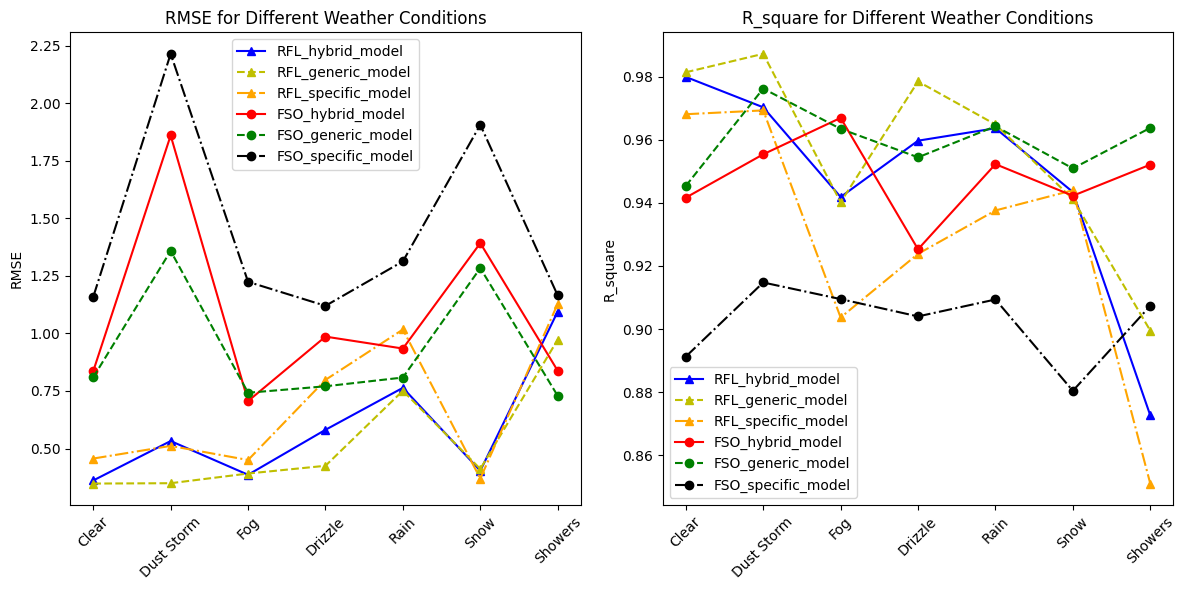

In [112]:
weather_list = ["Clear","Dust Storm","Fog","Drizzle","Rain","Snow","Showers"]
synop_codes = [0, 3, 4, 5, 6, 7, 8]
# Create the first subplot
FSO_specific_rmse_list = [1.158982264139424,2.215152452469044,1.224324068616785,1.1200685984855208,
 1.3132837442502583,1.9066897615483664,1.165079562152118]
RFL_specific_rmse_list = [0.4564406839512591,0.5113898930689583,0.4501033001987254,0.7983258849772373,1.0172438026519397,
 0.3694156589895368,1.12858283577548]
RFL_specific_r2_list= [0.9680698498717544,0.9692787649585118,0.9036510249030706,0.9238158078121552,
 0.9375699609372334,0.9439605125389304,0.8510264952119321]
FSO_specific_r2_list = [0.8912562687920282,0.9147437819281292,0.9094837050442288,0.9039914914517572,
 0.9093580716485414,0.8804147309144938,0.907351694228949]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(weather_list, RFL_hybrid_rmse_list1, color='b', marker='^', label='RFL_hybrid_model')
plt.plot(weather_list, RFL_generic_rmse_list, color='y', marker='^', linestyle='--', label='RFL_generic_model')
plt.plot(weather_list, RFL_specific_rmse_list, color='orange', marker='^', linestyle='-.', label='RFL_specific_model')
plt.plot(weather_list, FSO_hybrid_rmse_list1, color='r', marker='o', label='FSO_hybrid_model')
plt.plot(weather_list, FSO_generic_rmse_list, color='g', marker='o', linestyle='--', label='FSO_generic_model')
plt.plot(weather_list, FSO_specific_rmse_list, color='k', marker='o', linestyle='-.', label='FSO_specific_model')



# Add labels and title
plt.ylabel('RMSE')
plt.title('RMSE for Different Weather Conditions')
plt.xticks(rotation=45)
plt.legend()

# Create the second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(weather_list, RFL_hybrid_r2_list1, color='b', marker='^', label='RFL_hybrid_model')
plt.plot(weather_list, RFL_generic_r2_list, color='y', marker='^', linestyle='--', label='RFL_generic_model')
plt.plot(weather_list, RFL_specific_r2_list, color='orange', marker='^', linestyle='-.', label='RFL_specific_model')
plt.plot(weather_list, FSO_hybrid_r2_list1, color='r', marker='o', label='FSO_hybrid_model')
plt.plot(weather_list, FSO_generic_r2_list, color='g', marker='o', linestyle='--', label='FSO_generic_model')
plt.plot(weather_list, FSO_specific_r2_list, color='k', marker='o', linestyle='-.', label='FSO_specific_model')
# Add labels and title
plt.ylabel('R_square')
plt.title('R_square for Different Weather Conditions')
plt.xticks(rotation=45)
plt.legend() 

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [87]:
data = pd.read_csv("data_pre_process.csv")
data.loc[data["SYNOPCode"].isin([3, 5, 8]), "SYNOPCode"] = 9
weather_list = ["Clear","Drizzle","Rain","Snow","Dust/Fog/Showers"]
synop_codes = [0, 4, 6, 7, 9]


In [88]:
data["SYNOPCode"].unique()

array([0, 6, 9, 4, 7], dtype=int64)

In [89]:
FSO_hybrid_rmse_list1 = []
FSO_hybrid_r2_list1 = []
FSO_generic_rmse_list1 =[]
FSO_generic_r2_list1 =[]


for code in synop_codes:
    test_rfl_fso = pd.DataFrame()
    train_rfl_fso = pd.DataFrame()
    Xtrain_ori, Xval_ori, Ytrain_rfl, Yval_rfl = \
    train_test_split(data, data["RFL_Att"],test_size=0.3, random_state=42)
    
    Xtrain_rfl_s, Ytrain_rfl_s = ModelFunctions.filter_data_by_SYNOPCode(Xtrain_ori, Ytrain_rfl, code)
    Xval_rfl_s, Yval_rfl_s = ModelFunctions.filter_data_by_SYNOPCode(Xval_ori, Yval_rfl, code)
    # print(Xtrain_rfl_s.shape,Ytrain_rfl_s.shape)
    # print(Xval_rfl_s.shape,Yval_rfl_s.shape)

    # 原始的att.
    train_rfl_fso["rfl_ori"] = Ytrain_rfl_s
    train_rfl_fso["fso_ori"] = Xtrain_rfl_s["FSO_Att"]
    test_rfl_fso["rfl_ori"] = Yval_rfl_s
    test_rfl_fso["fso_ori"] = Xval_rfl_s["FSO_Att"]
    # print(train_rfl_fso,train_rfl_fso.shape)
    # print(test_rfl_fso,test_rfl_fso.shape)
    # rfl_first train and test X Yt
    Xval_rfl_s1 = Xval_rfl_s.drop(columns=["RFL_Att","FSO_Att"])
    Xval_fso_s1 = Xval_rfl_s.drop(columns=["RFL_Att","FSO_Att"])
    Xtrain_rfl_s1 = Xtrain_rfl_s.drop(columns=["RFL_Att","FSO_Att"])
    
    rfl_first_model = rfl_rf_model.fit(Xtrain_rfl_s1, Ytrain_rfl_s)
    ytrain_rfl_pred = rfl_first_model.predict(Xtrain_rfl_s1)
    ytest_rfl_pred = rfl_first_model.predict(Xval_rfl_s1)
 
    Xtrain_fso_s = Xtrain_rfl_s1
    Xtrain_fso_s['RFL_Att_pred'] = ytrain_rfl_pred
    Ytrain_fso = train_rfl_fso["fso_ori"]
    
    Xval_fso_s = Xval_rfl_s1
    Xval_fso_s['RFL_Att_pred'] = ytest_rfl_pred
    Yval_fso = test_rfl_fso["fso_ori"]

    fso_second_model = fso2_rf_model.fit(Xtrain_fso_s, Ytrain_fso)
    ytrain_fso_pred = fso_second_model.predict(Xtrain_fso_s)
    ytest_fso_pred = fso_second_model.predict(Xval_fso_s)

    test_fso_mse = mean_squared_error( test_rfl_fso["fso_ori"], ytest_fso_pred)
    test_fso_rmse = np.sqrt(test_fso_mse)
    test_fso_r2 = r2_score( test_rfl_fso["fso_ori"], ytest_fso_pred)

    FSO_hybrid_rmse_list1.append(test_fso_rmse)
    FSO_hybrid_r2_list1.append(test_fso_r2)



    with open('hybrid_fso_first_model.pkl', 'rb') as file:
            fso_first_model = pickle.load(file)
    ytest_fso_pred_first = fso_first_model.predict(Xval_fso_s1)
    
    test_fso_mse = mean_squared_error( test_rfl_fso["fso_ori"], ytest_fso_pred_first)
    test_fso_rmse = np.sqrt(test_fso_mse)
    test_fso_r2 = r2_score( test_rfl_fso["fso_ori"], ytest_fso_pred_first)

    FSO_generic_rmse_list1.append(test_fso_rmse)
    FSO_generic_r2_list1.append(test_fso_r2)



In [90]:
FSO_generic_rmse_list1

[0.8093048973890475,
 0.742349986465593,
 0.8084996658847207,
 1.283976616575483,
 0.813354501379579]

In [93]:
RFL_hybrid_rmse_list1 = []
RFL_hybrid_r2_list1 = []
RFL_generic_rmse_list1=[]
RFL_generic_r2_list1=[]

synop_codes = [0, 4, 6, 7, 9]

for code in synop_codes:
    test_rfl_fso = pd.DataFrame()
    train_rfl_fso = pd.DataFrame()
    Xtrain_ori, Xval_ori, Ytrain_fso, Yval_fso = \
    train_test_split(data, data["FSO_Att"],test_size=0.3, random_state=42)
    
    Xtrain_fso_s, Ytrain_fso_s = ModelFunctions.filter_data_by_SYNOPCode(Xtrain_ori, Ytrain_fso, code)
    Xval_fso_s, Yval_fso_s = ModelFunctions.filter_data_by_SYNOPCode(Xval_ori, Yval_fso, code)
    # print(Xtrain_rfl_s.shape,Ytrain_rfl_s.shape)
    # print(Xval_rfl_s.shape,Yval_rfl_s.shape)

    # 原始的att.
    train_rfl_fso["rfl_ori"] = Xtrain_fso_s["RFL_Att"]
    train_rfl_fso["fso_ori"] = Ytrain_fso_s
    test_rfl_fso["rfl_ori"] = Xval_fso_s["RFL_Att"]
    test_rfl_fso["fso_ori"] = Yval_fso_s
    # print(train_rfl_fso,train_rfl_fso.shape)
    # print(test_rfl_fso,test_rfl_fso.shape)
    # rfl_first train and test X Yt
    Xval_fso_s1 = Xval_fso_s.drop(columns=["RFL_Att","FSO_Att"])
    Xval_rfl_s1 = Xval_fso_s.drop(columns=["RFL_Att","FSO_Att"])
    Xtrain_fso_s1 = Xtrain_fso_s.drop(columns=["RFL_Att","FSO_Att"])
    
    fso_first_model = fso_rf_model.fit(Xtrain_fso_s1, Ytrain_fso_s)
    ytrain_fso_pred = fso_first_model.predict(Xtrain_fso_s1)
    ytest_fso_pred = fso_first_model.predict(Xval_fso_s1)
 
    Xtrain_rfl_s = Xtrain_fso_s1
    Xtrain_rfl_s['FSO_Att_pred'] = ytrain_fso_pred
    Ytrain_rfl = train_rfl_fso["rfl_ori"]
    
    Xval_rfl_s = Xval_fso_s1
    Xval_rfl_s['FSO_Att_pred'] = ytest_fso_pred
    Yval_rfl = test_rfl_fso["rfl_ori"]

    rfl_second_model = rfl2_rf_model.fit(Xtrain_rfl_s, Ytrain_rfl)
    ytrain_rfl_pred = rfl_second_model.predict(Xtrain_rfl_s)
    ytest_rfl_pred = rfl_second_model.predict(Xval_rfl_s)

    test_rfl_mse = mean_squared_error( test_rfl_fso["rfl_ori"], ytest_rfl_pred)
    test_rfl_rmse = np.sqrt(test_rfl_mse)
    test_rfl_r2 = r2_score( test_rfl_fso["rfl_ori"], ytest_rfl_pred)

    RFL_hybrid_rmse_list1.append(test_rfl_rmse)
    RFL_hybrid_r2_list1.append(test_rfl_r2)


    with open('hybrid_rfl_first_model.pkl', 'rb') as file:
            rfl_first_model = pickle.load(file)
    ytest_rfl_pred_first = rfl_first_model.predict(Xval_rfl_s1)
    
    test_rfl_mse = mean_squared_error( test_rfl_fso["rfl_ori"], ytest_rfl_pred_first)
    test_rfl_rmse = np.sqrt(test_rfl_mse)
    test_rfl_r2 = r2_score( test_rfl_fso["rfl_ori"], ytest_rfl_pred_first)

    RFL_generic_rmse_list1.append(test_rfl_rmse)
    RFL_generic_r2_list1.append(test_rfl_r2)


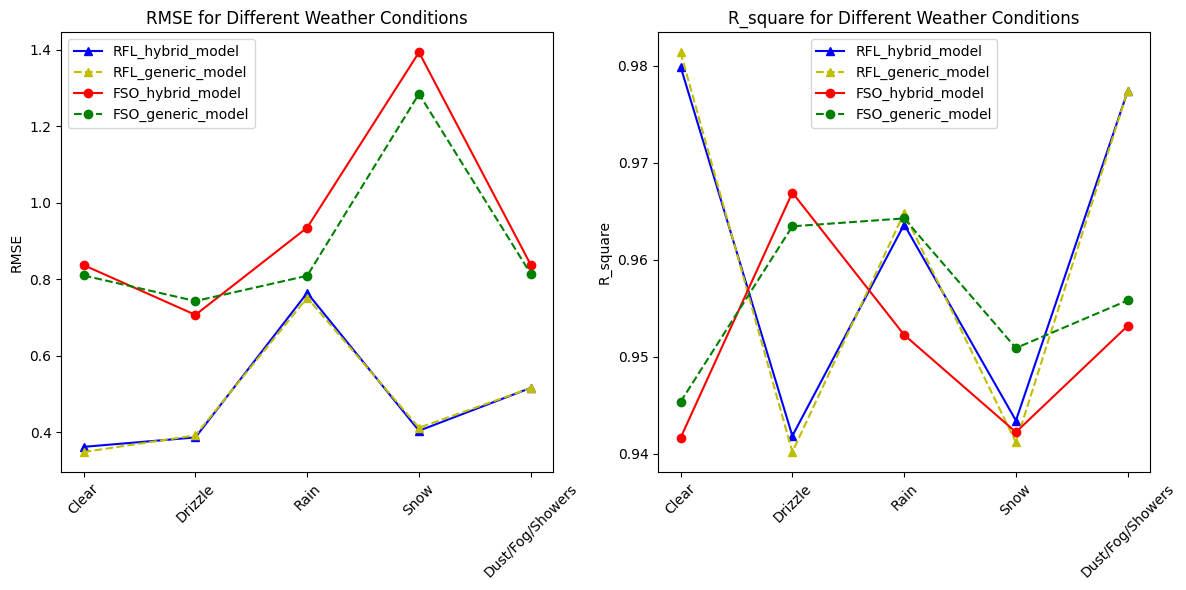

In [96]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(weather_list, RFL_hybrid_rmse_list1, color='b', marker='^', label='RFL_hybrid_model')
plt.plot(weather_list, RFL_generic_rmse_list1, color='y', marker='^', linestyle='--', label='RFL_generic_model')
plt.plot(weather_list, FSO_hybrid_rmse_list1, color='r', marker='o', label='FSO_hybrid_model')
plt.plot(weather_list, FSO_generic_rmse_list1, color='g', marker='o', linestyle='--', label='FSO_generic_model')

# Add labels and title
plt.ylabel('RMSE')
plt.title('RMSE for Different Weather Conditions')
plt.xticks(rotation=45)
plt.legend()

# Create the second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(weather_list, RFL_hybrid_r2_list1, color='b', marker='^', label='RFL_hybrid_model')
plt.plot(weather_list, RFL_generic_r2_list1, color='y', marker='^', linestyle='--', label='RFL_generic_model')
plt.plot(weather_list, FSO_hybrid_r2_list1, color='r', marker='o', label='FSO_hybrid_model')
plt.plot(weather_list, FSO_generic_r2_list1, color='g', marker='o', linestyle='--', label='FSO_generic_model')

# Add labels and title
plt.ylabel('R_square')
plt.title('R_square for Different Weather Conditions')
plt.xticks(rotation=45)
plt.legend() 

# Adjust layout and display the plot
plt.tight_layout()
plt.show()